In [65]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import constants
from scipy import signal

In [66]:
%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('ggplot')

# Required functions

In [67]:
eps0 = constants.epsilon_0
mu0 = constants.mu_0

In [68]:
def plot_resp_logy(x, y, title_name): # prints the freq response with dB on y axis
    plt.subplot(2, 1, 1)
    plt.semilogx(x, 20 * np.log10(abs(y)))
    plt.title(title_name)
    plt.ylabel('Magnitude (dB)')

    plt.subplot(2, 1, 2)
    plt.semilogx(x, np.angle(y))
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Phase (rad)')

def plot_resp(x, y, title_name): # prints the freq response with dB on y axis
    plt.subplot(2, 1, 1)
    plt.semilogx(x, abs(y))
    plt.title(title_name)
    plt.ylabel('Magnitude (linear)')

    plt.subplot(2, 1, 2)
    plt.semilogx(x, np.angle(y))
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Phase (rad)')

def plot_comparison_plot_at_z(w, Gamma0, z, Gamma_on, Gamma_off): # to check the plots (deprecated)
    plt.subplot(3, 1, 1)
    plt.semilogx(w, 20 * np.log10(abs(Gamma0)))
    plt.title("Comaprison Plot")
    plt.ylabel('Magnitude (dB)')

    plt.subplot(3, 1, 2)
    plt.semilogx(w, 20 * np.log10(abs(Gamma_on[:, z])))
    plt.title("Comaprison Plot")
    plt.ylabel('Magnitude (dB)')

    plt.subplot(3, 1, 3)
    plt.semilogx(w, 20 * np.log10(abs(Gamma_off[:, z])))
    plt.title("Comaprison Plot")
    plt.ylabel('Magnitude (dB)')

In [69]:
def calculate_gamma(w): # calculates gamma for a lossy TL
    beta_on = w*np.sqrt(30*eps0*mu0)
    beta_off = w*np.sqrt(eps0*mu0)
    alpha_on = 100*beta_on
    alpha_off = 100*beta_off
    return alpha_off+1j*beta_off, alpha_on+1j*beta_on

def synthesize_Gamma_for_element(Gamma0, gamma_on, gamma_off, l, num_pts_ele): # calculats for a lossy TL
    z = np.linspace(0, l, num_pts_ele)
    Gamma_element_on = np.zeros((num_pts_ele, len(Gamma0)), dtype=complex) # initialise to 0
    Gamma_element_off = Gamma_element_on # initialise to 0
    for i in range(0, num_pts_ele):
        Gamma_element_on[i, :] = Gamma0*np.exp(2*gamma_on*z[i])
        Gamma_element_off[i, :] = Gamma0*np.exp(2*gamma_off*z[i])
    return Gamma_element_on, Gamma_element_off

def compute_hamming_distance(x, y):
    d_arr = abs(x - y)
    return sum(d_arr)

def choose_switch_position(Gamma0, Gamma_element_on, Gamma_element_off):
    d_on = compute_hamming_distance(Gamma_element_on[-1, :], Gamma0)
    d_off = compute_hamming_distance(Gamma_element_off[-1, :], Gamma0)
    if d_on <= d_off:
        return 1
    else:
        return -1

def choose_new_Gamma0(curr_Gamma0, Gamma_element_on, Gamma_element_off):
    if choose_switch_position(curr_Gamma0, Gamma_element_on, Gamma_element_off):
        new_Gamma0 = Gamma_element_on[-1, :]
    else:
        new_Gamma0 = Gamma_element_off[-1, :]
    return new_Gamma0

# Line Charactaristics

The line is as follows

- L = 200 $\mu$
- $Z_L = 70 + j\omega 3\times10^9 \Omega$
- $R_g=50 \Omega$
- W = S = 20 $\mu$
- $L_{strip} = 3 \mu$
- $S_{strip} = 1\mu$
- $W_{strip} = 30\mu$

In [70]:
L = 200e-6
W = 20e-6
S = W
Lstrip = 3e-6
Sstrip = 1e-6
Wstrip = 30e-6

Rg = 50 # omega

We have
$$\Gamma(\omega, z)=\frac{Z_L-Z(\omega, z)}{Z_L+Z(\omega,z)}$$

We also want that $Z(\omega, L) = Z_L$

Assume we are given that $\Gamma(\omega, z)\Big|_{z=0}$ is a low pass chebyshev's filter

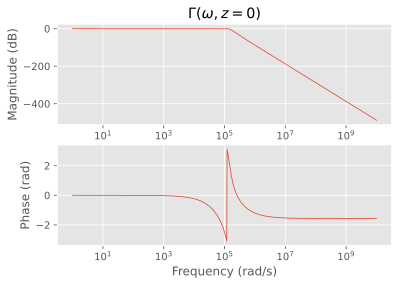

In [71]:
# Define filter parameters
order = 5
cutoff_freq = 1e5
ripple = 1e-3
b, a = signal.cheby1(order, ripple, cutoff_freq, 'low', analog=True)
Gamma0 = signal.TransferFunction(b, a)
w = np.logspace(0, 10, num=1000)
w, Gamma0 = signal.freqresp(Gamma0, w)

plot_resp_logy(w, Gamma0, '$\Gamma(\omega, z=0)$')

**Task** : to synthesize $Z(\omega, z)$ and thus $\epsilon(\omega, z)$ across the line
**Idea**
1. Divide the TL into $N$ parts where $N=\lfloor\frac{L}{L_{strip}+S_{strip}}\rfloor$
2. Each part of the line can either have an open or a closed switch, thus each part has a constant $Z(\omega)$
3. We denote the $i^{th}$ part by $Z(\omega, i) \forall i\in[0, N-1]$
4. Denote by $Z_{in_i}$ the input impedance seen by the ith element. Thus $Z_{in_N}=Z_L$.  
Also denote $Z_{o_i}$. Thus, $Z_{o_0}=R_g$
5. Also denote $\Gamma_{L_i}$ and $\Gamma_{0_i}$

We start at the source. Then, we find the $\Gamma$ at the start of the element. Using this, we can find $\Gamma$ at the end of the element, which will be the $\Gamma$ at the start for the next element

In [72]:
N = 8
l = L/N

Iterate across the elements

In [73]:
switches = np.zeros(N)
curr_Gamma0 = Gamma0
num_pts_ele = 100
for i in range(0, N):
    gamma_off, gamma_on = calculate_gamma(w)
    Gamma_ele_on, Gamma_ele_off = synthesize_Gamma_for_element(Gamma0=curr_Gamma0, gamma_on=gamma_on, gamma_off=gamma_off, l=l, num_pts_ele=num_pts_ele)
    switches[i] = choose_switch_position(Gamma0, Gamma_ele_on, Gamma_ele_off)
    curr_Gamma0 = choose_new_Gamma0(curr_Gamma0, Gamma_ele_off, Gamma_ele_on)

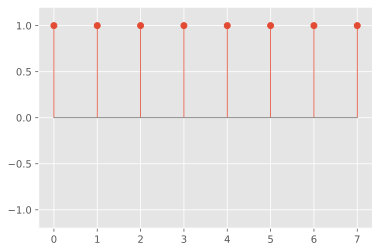

In [74]:
plt.figure()
plt.stem(np.arange(len(switches)), switches)
plt.ylim((-1.2, 1.2))
plt.show()